# 搜索引擎常用算法

1. TF-IDF算法
2. BM25算法

Counter是Python标准库collections中的一个类，它是一种集合类型，用于统计元素出现的次数。Counter能够接收任何可迭代对象作为输入，包括字符串、列表、元组等。

使用Counter可以很方便的统计一个序列中每个元素出现的次数，并以字典的形式返回结果。例如：

```python
from collections import Counter

lst = [1, 2, 3, 1, 2, 1, 4, 5, 3]
counter = Counter(lst)
print(counter)
```

输出结果为：

```
Counter({1: 3, 2: 2, 3: 2, 4: 1, 5: 1})
```

其中，Counter实例counter中存储了lst中每个元素出现的次数，可以通过类似字典的方式访问。例如，`counter[1]`的值就是3，表示数字1在lst中出现了3次。

tf shape(vecb in each docs):  (47, 15)

tf samples:
 [[0.         0.         0.         0.         0.         0.40546511
  0.69314718 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.69314718 0.         0.         0.69314718 0.         0.69314718
  0.         0.         0.69314718 0.         0.         0.
  0.         0.         0.69314718]]

idf shape(vecb in all docs):  (47, 1)

idf samples:
 [[3.7080502 ]
 [3.01490302]]

tf_idf shape:  (47, 15)

tf_idf sample:
 [[0.         0.         0.         0.         0.         1.50348498
  2.57022454 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [2.08977153 0.         0.         2.08977153 0.         2.08977153
  0.         0.         2.08977153 0.         0.         0.
  0.         0.         2.08977153]]
doc0, top2 keywords ['here', 'stay']
doc1, top2 keywords ['here', 'to']
doc2, top2 keywords ['am', 'I']

top 3 docs for 'I get a coffee cup':
['I have a party today

C:\Users\cong\AppData\Local\Temp\ipykernel_11728\929353820.py:115: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _idf = np.concatenate((idf, np.zeros((unknown_v, 1), dtype=np.float)), axis=0)
C:\Users\cong\AppData\Local\Temp\ipykernel_11728\929353820.py:116: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _tf_idf = np.concatenate((tf_idf, n

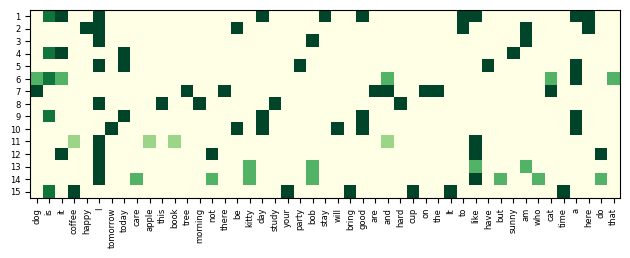

In [24]:
#@save
import numpy as np
import itertools
from collections import Counter
import matplotlib.pyplot as plt
import os

# 文档列表，模拟待扫描的文档
docs = [
    "it is a good day, I like to stay here",
    "I am happy to be here",
    "I am bob",
    "it is sunny today",
    "I have a party today",
    "it is a dog and that is a cat",
    "there are dog and cat on the tree",
    "I study hard this morning",
    "today is a good day",
    "tomorrow will be a good day",
    "I like coffee, I like book and I like apple",
    "I do not like it",
    "I am kitty, I like bob",
    "I do not care who like bob, but I like kitty",
    "It is coffee time, bring your cup",
]

docs_words = [d.replace(",", "").split(" ") for d in docs]  #所有文档中的总单词数（未去重）
# chain函数可以接受多个可迭代对象（iterables）作为参数，将它们连接起来，并返回一个新的迭代器。
# *docs_words 表示将 docs_words 中的所有元素解包成单独的参数传递给chain函数
vocab = set(itertools.chain(*docs_words))  #所有文档中的总单词数（去重）
# v2i和i2v就是把键和值进行对调
v2i = {v: i for i, v in enumerate(vocab)}
i2v = {i: v for v, i in v2i.items()}


# print(v2i)
# print(i2v)

# 将非零元素取对数，0元素保持不变，返回处理后的函数
def save_log(x):
    """将输入的数组x中非零元素取对数，零元素保持不变，并返回处理后的数组
    输入的x必须是nd.array形式，list或者别的格式不好使"""
    mask = x != 0
    x[mask] = np.log(x[mask])
    return x


# 定义TF和IDF的相关计算方法
tf_methods = {
    "log": lambda x: np.log(1 + x),
    "augmented": lambda x: 0.5 + 0.5 * x / np.max(x, axis=1, keepdims=True),
    "boolean": lambda x: np.minimum(x, 1),
    "log_avg": lambda x: (1 + safe_log(x)) / (1 + safe_log(np.mean(x, axis=1, keepdims=True))),
}
idf_methods = {
    "log": lambda x: 1 + np.log(len(docs) / (x + 1)),
    "prob": lambda x: np.maximum(0, np.log((len(docs) - x) / (x + 1))),
    "len_norm": lambda x: x / (np.sum(np.square(x)) + 1),
}


def get_tf(method="log"):
    # 统计某个词元在一个文档中出现的次数并据此赋权，输出是一个(词元数*文档数)的权重矩阵
    # 词元频次：一个单词在一个文档中出现的次数
    _tf = np.zeros((len(vocab), len(docs)), dtype=np.float64)  #词元长度*文档数
    for i, d in enumerate(docs_words):
        counter = Counter(d)  # 统计每个文档中各个词元出现的次数
        for v in counter.keys():
            _tf[v2i[v], i] = counter[v] / counter.most_common(1)[0][
                1]  # 统计频次最高的元素及其出现次数，counter.most_common(1)[0][0]返回出现次数最多的数，counter.most_common(1)[0][1]返回出现次数最高的数的出现频次
    weighted_tf = tf_methods.get(method, None)
    if weighted_tf is None:
        raise ValueError
    return weighted_tf(_tf)


def get_idf(method="log"):
    # 反向文档频次：低idf意味着一个词元同时存在与大多数文档中，重要性相对更低
    df = np.zeros((len(i2v), 1))  #去重后的词元数*1
    for i in range(len(i2v)):
        d_count = 0
        for d in docs_words:
            d_count += 1 if i2v[i] in d else 0
        df[1, 0] = d_count

    idf_fn = idf_methods.get(method, None)
    if idf_fn is None:
        raise ValueError
    return idf_fn(df)


def cosine_similarity(q, _tf_idf):
    """
    q是一个查询向量，它表示一个查询单词的TF-IDF权重。
    _tf_idf是一个矩阵，它表示所有文档中所有单词的TF-IDF权重（每列代表一个文档）。
    """
    unit_q = q / np.sqrt(np.sum(np.square(q), axis=0, keepdims=True))
    unit_ds = _tf_idf / np.sqrt(np.sum(np.square(_tf_idf), axis=0, keepdims=True))
    similarity = unit_ds.T.dot(unit_q).ravel()
    return similarity


# 计算文档评分矩阵
def docs_score(q, idf, tf_idf, len_norm=False):
    q_words = q.replace(",", "").split(" ")

    # add unknown words
    unknown_v = 0
    for v in set(q_words):
        if v not in v2i:
            v2i[v] = len(v2i)
            i2v[len(v2i) - 1] = v
            unknown_v += 1
    if unknown_v > 0:
        _idf = np.concatenate((idf, np.zeros((unknown_v, 1), dtype=np.float)), axis=0)
        _tf_idf = np.concatenate((tf_idf, np.zeros((unknown_v, tf_idf.shape[1]), dtype=np.float)), axis=0)
    else:
        _idf, _tf_idf = idf, tf_idf
    counter = Counter(q_words)
    q_tf = np.zeros((len(_idf), 1), dtype=np.float)  # [n_vocab, 1]
    for v in counter.keys():
        q_tf[v2i[v], 0] = counter[v]

    q_vec = q_tf * _idf  # [n_vocab, 1]

    q_scores = cosine_similarity(q_vec, _tf_idf)
    if len_norm:
        len_docs = [len(d) for d in docs_words]
        q_scores = q_scores / np.array(len_docs)
    return q_scores


# 获取每个文档的前n个关键词
def get_keywords(tf_idf,n=2):
    for c in range(3):
        col = tf_idf[:, c]
        idx = np.argsort(col)[-n:]
        print("doc{}, top{} keywords {}".format(c, n, [i2v[i] for i in idx]))


def show_tfidf(tfidf, vocab, filename):
    # [n_doc, n_vocab]
    plt.imshow(tfidf, cmap="YlGn", vmin=tfidf.min(), vmax=tfidf.max())
    plt.xticks(np.arange(tfidf.shape[1]), vocab, fontsize=6, rotation=90)
    plt.yticks(np.arange(tfidf.shape[0]), np.arange(1, tfidf.shape[0] + 1), fontsize=6)
    plt.tight_layout()
    # creating the output folder
    output_folder = './figs/'
    os.makedirs(output_folder, exist_ok=True)
    plt.savefig(os.path.join(output_folder, '%s.png') % filename, format="png", dpi=500)
    plt.show()

tf = get_tf()           # [n_vocab, n_doc]
idf = get_idf()         # [n_vocab, 1]
tf_idf = tf * idf       # [n_vocab, n_doc]
print("tf shape(vecb in each docs): ", tf.shape)
print("\ntf samples:\n", tf[:2])
print("\nidf shape(vecb in all docs): ", idf.shape)
print("\nidf samples:\n", idf[:2])
print("\ntf_idf shape: ", tf_idf.shape)
print("\ntf_idf sample:\n", tf_idf[:2])

# test
get_keywords(tf_idf)
q = "I get a coffee cup"
scores = docs_score(q,idf, tf_idf)
d_ids = scores.argsort()[-3:][::-1]
print("\ntop 3 docs for '{}':\n{}".format(q, [docs[i] for i in d_ids]))

show_tfidf(tf_idf.T, [i2v[i] for i in range(tf_idf.shape[0])], "tfidf_matrix")

sklearn实现TF-IDF算法

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 使用sklearn实现TF-IDF算法u
vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(docs)
print("idf: ", [(n, idf) for idf, n in zip(vectorizer.idf_, vectorizer.get_feature_names())])
print("v2i: ", vectorizer.vocabulary_)


q = "I get a coffee cup"
qtf_idf = vectorizer.transform([q])
res = cosine_similarity(tf_idf, qtf_idf)
res = res.ravel().argsort()[-3:]
print("\ntop 3 docs for '{}':\n{}".format(q, [docs[i] for i in res[::-1]]))


i2v = {i: v for v, i in vectorizer.vocabulary_.items()}
dense_tfidf = tf_idf.todense()
show_tfidf(dense_tfidf, [i2v[i] for i in range(dense_tfidf.shape[1])], "tfidf_sklearn_matrix")

jieba库实现TF-IDF和text-rank算法

In [ ]:
from jieba import analyse
# 引入TF-IDF关键词抽取接口
tfidf = analyse.extract_tags
# 引入TextRank关键词抽取接口
textrank = analyse.textrank


# 原始文本
text = "线程是程序执行时的最小单位，它是进程的一个执行流，\
        是CPU调度和分派的基本单位，一个进程可以由很多个线程组成，\
        线程间共享进程的所有资源，每个线程有自己的堆栈和局部变量。\
        线程由CPU独立调度执行，在多CPU环境下就允许多个线程同时运行。\
        同样多线程也可以实现并发操作，每个请求分配一个线程来处理。"

# 基于TF-IDF算法进行关键词抽取
keywords = tfidf(text)
print("keywords by tf-idf:")
# 输出抽取出的关键词
for keyword in keywords:
    print(keyword + "/",)

jieba库可以用于中文自然语言处理，它提供了一些常见的文本分析算法，包括TF-IDF和text-rank。

TF-IDF是一种常见的文本特征提取方法，其全称为“Term Frequency-Inverse Document Frequency”，即词频-逆文档频率。它通过统计每个词在文档中出现的次数和该词在整个语料库中出现的文档频率来评估一个词在当前文档中的重要性。TF-IDF算法可以用于文本分类、关键字提取等任务。

text-rank是一种基于图论的算法，它将文本中的词语看作节点，将词与词之间的共现关系看作边，并计算每个节点的权重。text-rank算法可以用于文本摘要、关键字提取等任务。

TF-IDF和text-rank算法虽然都是用于文本特征提取和信息检索的算法，但二者的本质不同。TF-IDF算法是基于词频和文档频率的统计特征提取方法，而text-rank算法则是基于图论的排名算法。

联系方面，TF-IDF和text-rank算法都可以用于文本关键字提取这一任务。同时，它们也可以结合使用，比如在用text-rank算法提取关键句子时，可以利用TF-IDF算法来对每个句子进行权重计算，这样就可以提高text-rank算法的精度。

总之，TF-IDF和text-rank算法在文本分析中都有着重要的应用，二者的选择取决于具体的任务需求。

In [ ]:
import sys
from jieba import itervalues
from operator import itemgetter
#@save
# text-rank算法原理
from collections import defaultdict
import networkx as nx


def textrank(self, sentence, topK=20, withWeight=False, allowPOS=('ns', 'n', 'vn', 'v'), withFlag=False):
    self.pos_filt = frozenset(allowPOS)
    # 在Python中，frozenset是一个不可变的集合对象，它类似于set，但是一旦创建就不能被修改。因此，它可以作为字典的键或其他需要不可变对象的场合使用。
    # 与set相比，frozenset没有add()和remove()等修改集合的方法。但是，它支持所有set支持的操作，例如并集、交集、差集等。

    # 定义无向有权图
    g = nx.Graph()
    # 定义共现词典
    cm=defaultdict(int)
    # 分词
    words=tuple(self.tokenizer.cut(sentence))
    # 依次遍历每个词
    for i,wp in enumerate(words):
        # 词i满足过滤条件
        if self.pairfilter(wp):
            # 依次遍历词i之后窗口范围内的词
            for j in range(i+1,i+self.span):
                # 词j 不能超出整个句子
                if j >= len(words):
                    break
                # 词j不满足过滤条件，则跳过
                if not self.pairfilter(words[j]):
                    continue
                # 将词i和词j作为key，出现的次数作为value，添加到共现词典中
                if allowPOS and withFlag:
                    cm[(wp, words[j])] += 1
                else:
                    cm[(wp.word, words[j].word)] += 1
    # 依次遍历共现词典的每个元素，将词i，词j作为一条边起始点和终止点，共现的次数作为边的权重
    for terms, w in cm.items():
        g.addEdge(terms[0], terms[1], w)

        # 运行textrank算法
    nodes_rank = g.rank()

    # 根据指标值进行排序
    if withWeight:
        tags = sorted(nodes_rank.items(), key=itemgetter(1), reverse=True)
    else:
        tags = sorted(nodes_rank, key=nodes_rank.__getitem__, reverse=True)

    # 输出topK个词作为关键词
    if topK:
        return tags[:topK]
    else:
        return tags

def addEdge(self, start, end, weight):
    # use a tuple (start, end, weight) instead of a Edge object
    self.graph[start].append((start, end, weight))
    self.graph[end].append((end, start, weight))

def rank(self):
    ws = defaultdict(float)
    outSum = defaultdict(float)

    wsdef = 1.0 / (len(self.graph) or 1.0)
    # 初始化各个结点的权值
    # 统计各个结点的出度的次数之和
    for n, out in self.graph.items():
        ws[n] = wsdef
        outSum[n] = sum((e[2] for e in out), 0.0)

    # this line for build stable iteration
    sorted_keys = sorted(self.graph.keys())
    # 遍历若干次
    for x in range(10):  # 10 iters
        # 遍历各个结点
        for n in sorted_keys:
            s = 0
            # 遍历结点的入度结点
            for e in self.graph[n]:
                # 将这些入度结点贡献后的权值相加
                # 贡献率 = 入度结点与结点n的共现次数 / 入度结点的所有出度的次数
                s += e[2] / outSum[e[1]] * ws[e[1]]
            # 更新结点n的权值
            ws[n] = (1 - self.d) + self.d * s

    (min_rank, max_rank) = (sys.float_info[0], sys.float_info[3])

    # 获取权值的最大值和最小值
    for w in itervalues(ws):
        if w < min_rank:
            min_rank = w
        if w > max_rank:
            max_rank = w

    # 对权值进行归一化
    for n, w in ws.items():
        # to unify the weights, don't *100.
        ws[n] = (w - min_rank / 10.0) / (max_rank - min_rank / 10.0)

    return ws